In [1]:
import sys
import xarray as xr
import numpy as np
import Plotter
from Plotter import Plotter
import time
from preprocessing_utils import *
import pandas as pd
import sklearn
import pyxpcm
from pyxpcm.models import pcm

In [2]:
def train_model(k, x, var_name_ds, algo):
    if algo == "kmean":
        print("model used: kmean")
        model = sklearn.cluster.KMeans(n_clusters=k, n_init=10, max_iter=1000)
    elif algo == "batch":
        print("model used: mini batch kmean")
        model = sklearn.cluster.MiniBatchKMeans(n_clusters=k, n_init=10, max_iter=1000, batch_size=100)
    else:
        print("model used: GMM")
        model = sklearn.mixture.GaussianMixture(n_components=k, max_iter=1000, tol=1e-6)
    model.fit(x[var_name_ds])
    return model

In [10]:
def predict(x, m, var_name_ds, k, var_predict):
    classif = m.predict(x[var_predict])
    x = x.assign(variables={"labels": ('sample_dim', classif)})
    q = [0.05, 0.5, 0.95]
    x = compute_quantile(x, var_name_ds, k, q)
    x = x.assign_coords(coords={'k': range(k)})
    x = x.unstack('sample_dim')
    return x

In [4]:
def generate_plots(ds, var_name_ds, k):
    """
    Generates and saves the following plots:
    - vertical structure: vertical structure of each classes. It draws the mean profile and the 0.05 and 0.95 quantiles
    - vertical structure comp: vertical structure graph but Quantiles are being plotted together to highlight
    differences between classes.
    - Spacial distribution: plot the PCM labels in a map to analyse the spatial coherence of classes.
    - Robustness: spacial distribution of a scaled probability of a profile to belong to a class.
    - Pie chart: pie chart showing the percentage of profiles belonging to each class and the number of
    classified profiles.
    - Temporal distribution by month: The bar plots represents the percentage of profiles in each class by month.
    - Temporal distribution by season: The bar plots represents the percentage of profiles in each class by season.
    Parameters
    ----------
    ds : Xarray dataset containing the predictions
    var_name_ds : name of the variable in the dataset

    Returns
    -------
    saves all the plots as png
    """
    if ds[var_name_ds].attrs['unit_long'] and ds[var_name_ds].attrs['long_name']:
        x_label = ds[var_name_ds].attrs['long_name'] + " in " + ds[var_name_ds].attrs['unit_long']
    else:
        x_label = var_name_ds

    # create a pyXpcm model to use the Plotter class
    var_name_mdl = var_name_ds
    z_dim = 'depth'
    z = ds[z_dim]
    pcm_features = {var_name_mdl: z}
    m = pcm(K=k, features=pcm_features)
    ds = ds.rename({'labels': 'PCM_LABELS'})
    ds = ds.sortby('latitude').sortby('longitude')
    P = Plotter(ds, m, coords_dict={'latitude': 'latitude', 'longitude': 'longitude', 'time': 'time', 'depth': 'depth'})

    # plot profiles by class
    P.vertical_structure(q_variable=var_name_ds + '_Q', sharey=True, xlabel=x_label)
    P.save_BlueCloud('tmp_out/vertical_struc.png')
    # plot profiles by quantile
    P.vertical_structure_comp(q_variable=var_name_ds + '_Q', plot_q='all', xlabel=x_label)
    P.save_BlueCloud('tmp_out/vertical_struc_comp.png')
    # spacial distribution
    P.spatial_distribution(time_slice='most_freq_label')
    P.save_BlueCloud('tmp_out/spatial_distr_freq.png')
    # robustness
    # P.plot_robustness(time_slice=first_date)
    # P.save_BlueCloud('robustness.png')
    # pie chart of the classes distribution
    P.pie_classes()
    P.save_BlueCloud('tmp_out/pie_chart.png')
    # temporal distribution (monthly)
    P.temporal_distribution(time_bins='month')
    P.save_BlueCloud('tmp_out/temporal_distr_months.png')
    # temporal distribution (seasonally)
    P.temporal_distribution(time_bins='season')
    P.save_BlueCloud('tmp_out/temporal_distr_season.png')
    # save data
    ds.to_netcdf('predicted_dataset.nc', format='NETCDF4')

# Execution of the code

## parameters

In [15]:
var_name_ds = "thetao"
var_name_mdl = "temperature"
# algorithm choice can be: "kmean" for classic sklarn kmean, "batch" for sklearn kmean mini-batch, "GMM" for sklearn GMM
algorithm = "GMM"
k = 8
file_name = '../datasets/global-reanalysis-phy-001-030-monthly_med_2018.nc' 

## Load and preprocessing
see in file preprocessing utils for details

In [20]:
print("loading the dataset")
start_time = time.time()
x = preprocessing_allin(path=file_name, scaling=True, multiple=False, backend='sk', var_name=var_name_ds)
load_time = time.time() - start_time
print("preprocessing finished in " + str(load_time) + "sec")
x

loading the dataset
size full DS: 0.1998654119670391 Go
size after selection of variable: 0.1998654119670391 Go
preprocessing finished in 1.6361877918243408sec


<xarray.Dataset>
Dimensions:                (depth: 30, feature: 30, feature_reduced: 4, sample_dim: 388788)
Coordinates:
  * depth                  (depth) float32 -0.494 -1.541 ... -318.1 -380.2
  * sample_dim             (sample_dim) MultiIndex
  - time                   (sample_dim) datetime64[ns] 2018-01-16T12:00:00 .....
  - latitude               (sample_dim) float64 30.75 30.75 30.75 ... 46.0 46.0
  - longitude              (sample_dim) float64 19.08 19.17 ... -4.0 -3.917
Dimensions without coordinates: feature, feature_reduced
Data variables:
    thetao                 (sample_dim, depth) float32 18.72 18.72 ... 11.46
    thetao_scaled          (sample_dim, feature) float32 -0.3181 ... -0.9683
    thetao_scaled_reduced  (sample_dim, feature_reduced) float32 -1.904 ... 0...

## Training

In [ ]:
print("starting computation")
start_time = time.time()
m = train_model(k=k, x=x, var_name_ds=var_name_ds + "_scaled_reduced", algo=algorithm)
train_time = time.time() - start_time
print("training finished in " + str(train_time) + "sec")

starting computation
model used: GMM


## Prediction and quantile computation

In [ ]:
start_time = time.time()
ds = predict(m=m, x=x, var_name_ds=var_name_ds, var_predict = var_name_ds + "_scaled_reduced", k=k)
prediction_time = time.time() - start_time
print("prediction finished in " + str(prediction_time) + "sec")

## Plots

Figure saved in tmp_out/vertical_struc.png
Figure saved in tmp_out/vertical_struc_comp.png


/home1/datahome/lbachelo/.local/lib/python3.8/site-packages/pyxpcm/plot.py:111: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  colorbar = plt.colorbar(mappable, **kwargs)
/home1/datahome/lbachelo/conda-env/OceanPatterns2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home1/datahome/lbachelo/conda-env/OceanPatterns2/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Figure saved in tmp_out/spatial_distr_freq.png
Figure saved in tmp_out/pie_chart.png


/home1/datahome/lbachelo/Documents/speed_test/Plotter.py:766: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xaxis_labels, fontsize=12)


Figure saved in tmp_out/temporal_distr_months.png
Figure saved in tmp_out/temporal_distr_season.png
plot finished in 128.61879658699036sec
{'ncpu': 8, 'ram': 16, 'platform': 'local', 'time_load': 1.6635479927062988, 'time_train': 31.517444372177124, 'time_prediction': 0.9482331275939941, 'time_plot': 128.61879658699036, 'total_time': 162.74802207946777, 'file_size': 0.3034806028008461}
exec time saved


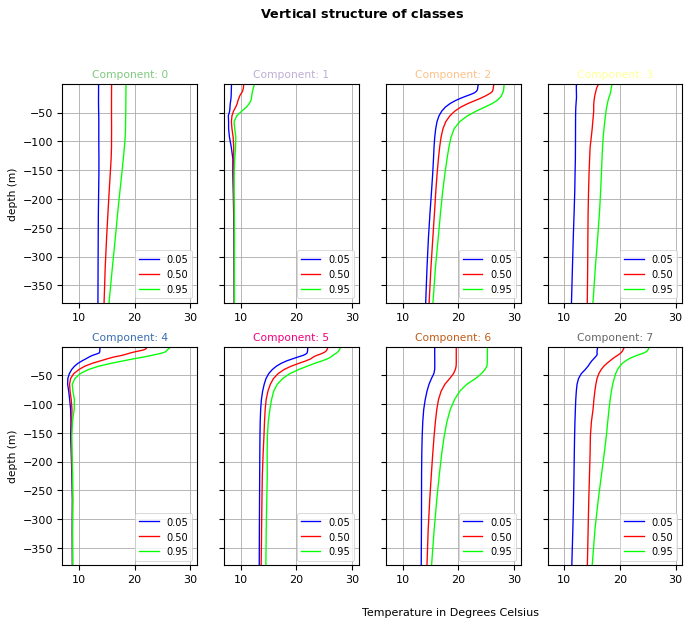

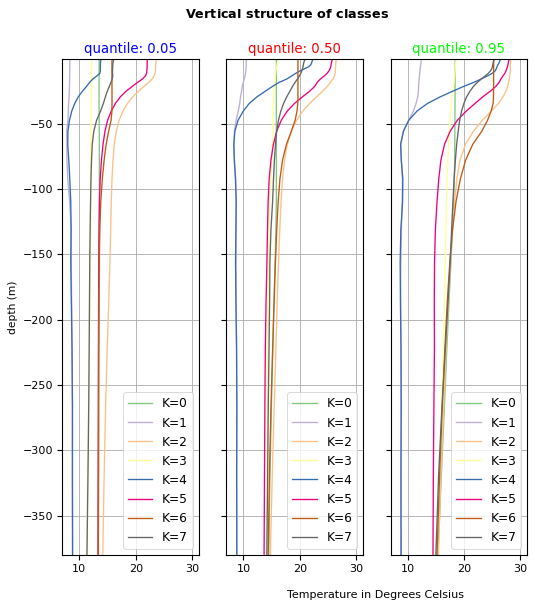

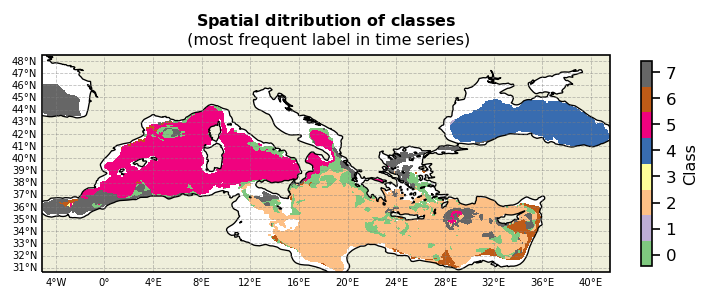

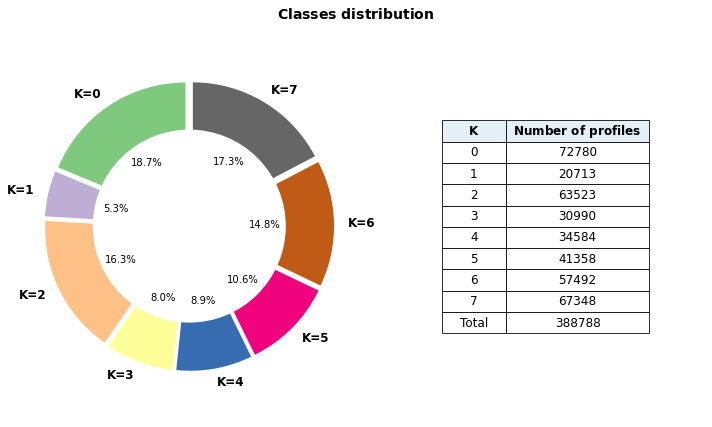

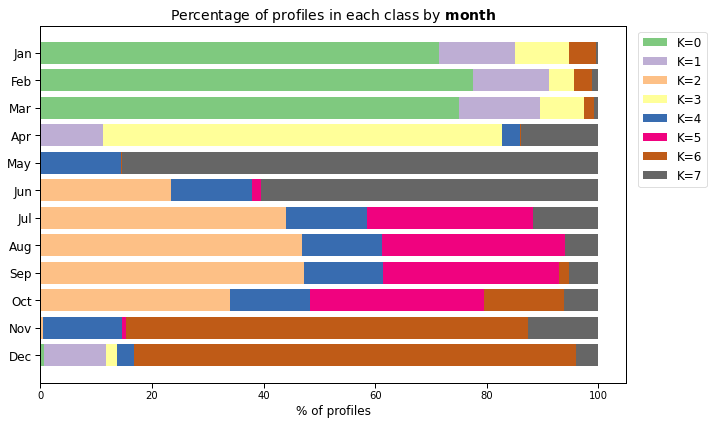

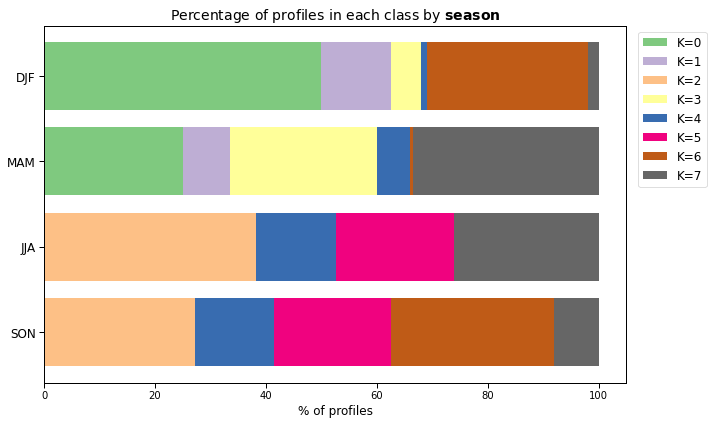

In [19]:
start_time = time.time()
generate_plots(ds=ds, var_name_ds=var_name_ds, k=k)
plot_time = time.time() - start_time
print("plot finished in " + str(plot_time) + "sec")
tmp_log = {
    'ncpu': 8,
    'ram': 16,
    'platform': "local",
    'time_load': load_time,
    'time_train': train_time,
    'time_prediction': prediction_time,
    'time_plot': plot_time,
    'total_time': load_time + train_time + prediction_time + plot_time,
    'file_size': (ds.nbytes / 1073741824),
}
print(tmp_log)
print("exec time saved")